In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
from numpy.random import RandomState
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
def resize_image(input_path, size=(224, 224)):
    # Abrir la imagen
    image = Image.open(input_path).convert("L")  # Convertir a escala de grises
    
    # Obtener tamaño original
    original_width, original_height = image.size
    aspect_ratio = original_width / original_height
    
    # Calcular nuevo tamaño
    if aspect_ratio > 1:
        # Imagen más ancha que alta
        new_width = size[0]
        new_height = int(new_width / aspect_ratio)
    else:
        # Imagen más alta que ancha
        new_height = size[1]
        new_width = int(new_height * aspect_ratio)
    
    # Redimensionar la imagen manteniendo la relación de aspecto
    # si la imagen es mas chica que el tamaño deseado, uso interpolación LANCZOS, sino LINEAL
    if original_width < size[0] or original_height < size[1]:
        resized_image = image.resize((new_width, new_height), Image.LANCZOS)
    else:
        resized_image = image.resize((new_width, new_height), Image.BILINEAR)
    
    # Crear un nuevo fondo de 224x224 y pegar la imagen redimensionada en el centro
    new_image = Image.new("L", size)
    new_image.paste(resized_image, ((size[0] - new_width) // 2, (size[1] - new_height) // 2))
    
    return new_image

In [3]:
# show original image
image = Image.open("CelebA/celebA/img_align_celeba/img_align_celeba/125478.jpg")
image.show()

# image size
print("original image size:", image.size)

# resize image
resized_image = resize_image("CelebA/celebA/img_align_celeba/img_align_celeba/125478.jpg", size=(224, 224))
resized_image.show()

# resized image size
print("resized image size:", resized_image.size)

original image size: (178, 218)
resized image size: (224, 224)


In [4]:
# save resized image as jpg
resized_image.save("125478_resized.jpg")

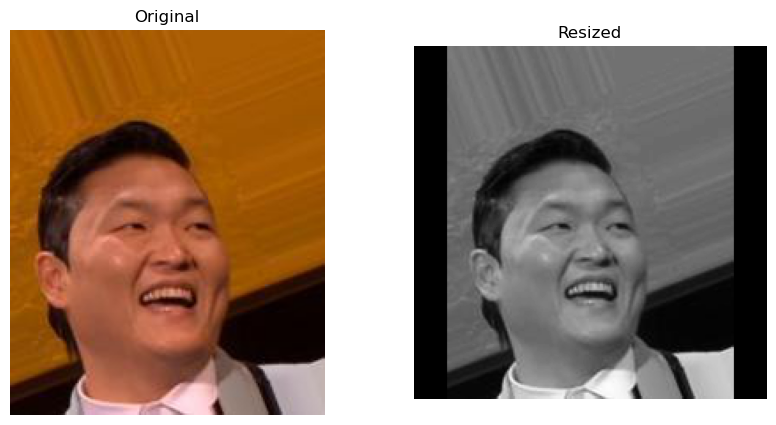

In [5]:
# show resized image in subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original")
ax[0].axis("off")
# show in gray scale and without axis
ax[1].imshow(resized_image, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Resized")
plt.show()

## Add Noise to images

In [6]:
def add_noise_to_image(image_array, noise_level=0.02, seed=42):
    """
    Agrega ruido gaussiano a una imagen.
    
    Parámetros:
        image_array (numpy.array): Imagen de entrada en formato de array NumPy.
        noise_level (float): Nivel de ruido como fracción de la intensidad máxima de la imagen (0-1).
        seed (int): Seed para la generación de números aleatorios, para reproducibilidad.
    
    Retorna:
        numpy.array: Imagen con ruido añadido.
    """
    rng = RandomState(seed)
    mean = 0
    std = noise_level * 255  # Escalar el nivel de ruido por la intensidad máxima de un pixel
    
    # Crear ruido gaussiano
    gauss = rng.normal(mean, std, image_array.shape)
    
    # Agregar ruido a la imagen original
    noisy_image = image_array + gauss
    noisy_image = np.clip(noisy_image, 0, 255)  # Asegurarse de que los valores estén dentro del rango válido para uint8
    
    return noisy_image.astype(np.uint8)

In [7]:
# Hacer prueba de agregar ruido a la imagen: CelebA/celebA/img_align_celeba/img_align_celeba/125478.jpg
image_array = np.array(resized_image)
noisy_image_array = add_noise_to_image(image_array, noise_level=0.03, seed=42)
noisy_image = Image.fromarray(noisy_image_array)
noisy_image.show()

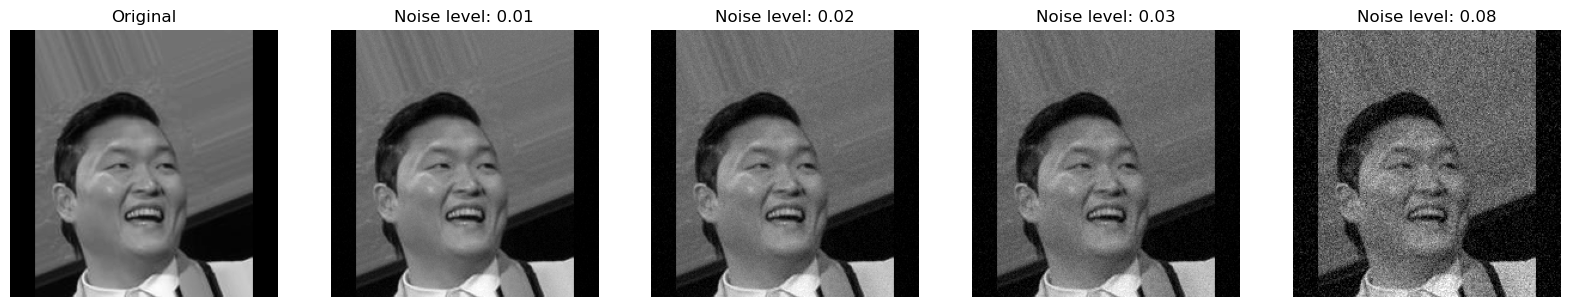

In [8]:
# subplot of original and different noise-level images (0.01, 0.02, 0.05, 0.1)
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(resized_image, cmap="gray")
ax[0].set_title("Original")
ax[0].axis("off")

for i, noise_level in enumerate([0.01, 0.02, 0.03, 0.08]):
    noisy_image_array = add_noise_to_image(image_array, noise_level=noise_level, seed=42)
    ax[i + 1].imshow(noisy_image_array, cmap="gray")
    ax[i + 1].set_title(f"Noise level: {noise_level}")
    ax[i + 1].axis("off")

plt.show()

## Pre-process all images in CelebA to 256x256

In [59]:
# resize all images in celebA dataset to 256x256, and save them in a single more efficient .npy file
input_dir = "CelebA/celebA/img_align_celeba/img_align_celeba/"

# get all image paths
image_paths = [os.path.join(input_dir, image_name) for image_name in os.listdir(input_dir)]

# create a numpy array to store all images
images = np.zeros((len(image_paths), 256, 256), dtype=np.uint8)
original_images = np.zeros((len(image_paths), 256, 256), dtype=np.uint8)

# resize and add noise to all images
for i, image_path in enumerate(image_paths):
    image = resize_image(image_path, size=(256, 256))
    original_images[i] = np.array(image)
    image = add_noise_to_image(np.array(image), noise_level=0.03, seed=42)
    images[i] = np.array(image)

# save images in a single .npy file
np.save("celeba_original", original_images)
np.save("celeba_noisy", images)

In [60]:
# guardar en otro archivo .npy solo 1000 imágenes
np.save("original_1000_train", original_images[:1000])
np.save("noisy_1000_train", images[:1000])

In [61]:
# guardar en otro archivo .npy solo 1000 imágenes
np.save("original_300_test", original_images[1000:1300])
np.save("noisy_300_test", images[1000:1300])

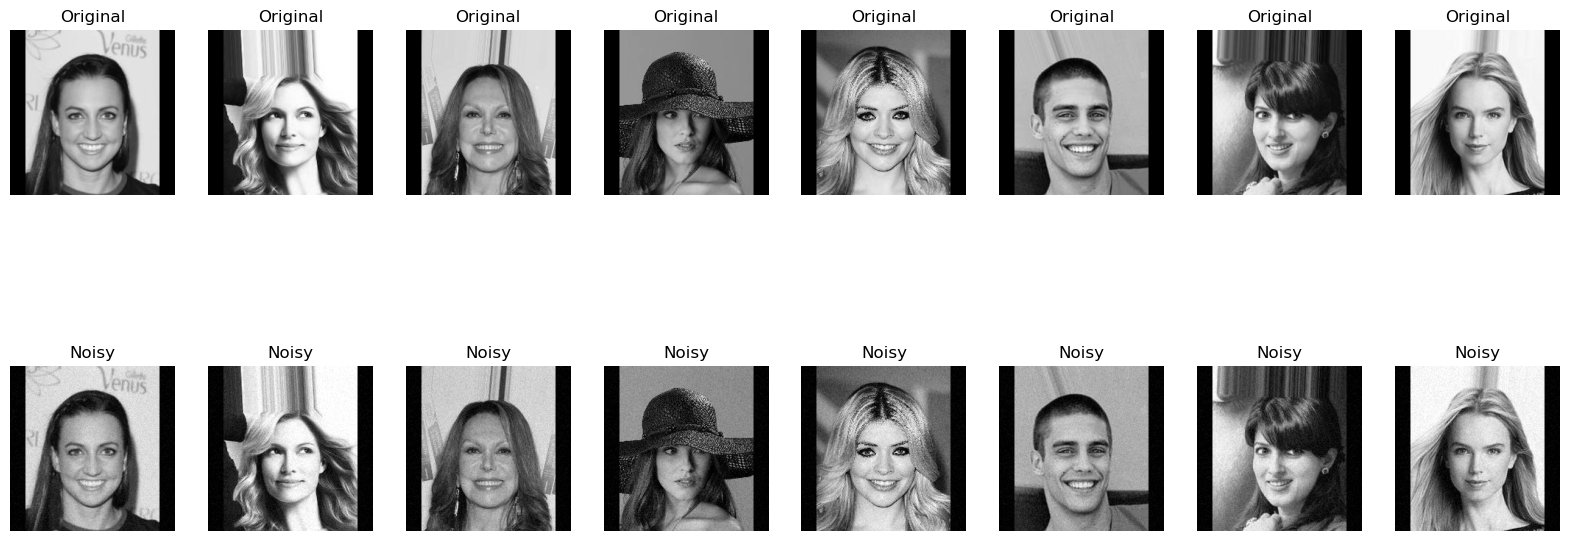

In [32]:
# show in subplot the original and pre-processed images of the first 8 images
fig, ax = plt.subplots(2, 8, figsize=(20, 8))

for i in range(8):
    ax[0, i].imshow(original_images[i], cmap="gray")
    ax[0, i].set_title("Original")
    ax[0, i].axis("off")
    
    ax[1, i].imshow(images[i], cmap="gray")
    ax[1, i].set_title("Noisy")
    ax[1, i].axis("off")

plt.show()

### Load images from celeba_pre-processed.npy

In [31]:
noisy_images = np.load('celeba_noisy.npy')
original_images = np.load('celeba_original.npy')

print("images.shape:", noisy_images.shape)
print("original_images.shape:", original_images.shape)

images.shape: (77122, 224, 224)
original_images.shape: (77122, 224, 224)


In [32]:
# pixel values range
print("Pixel values range in images[0]: ({}, {})".format(noisy_images[0].min(), noisy_images[0].max()))
print("Pixel values range in original_images[0]: ({}, {})".format(original_images[0].min(), original_images[0].max()))


Pixel values range in images[0]: (0, 255)
Pixel values range in original_images[0]: (0, 250)


## Denoising Model with VAE

In [33]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 1024),
            nn.ReLU()
        )
        
        # Latent space
        self.fc_mu = nn.Linear(1024, 50)  # Mean vector
        self.fc_logvar = nn.Linear(1024, 50)  # Log variance vector

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(50, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 28 * 28),
            nn.ReLU(),
            nn.Unflatten(1, (128, 28, 28)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [34]:
# model summary
model = VAE()
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=100352, out_features=1024, bias=True)
    (8): ReLU()
  )
  (fc_mu): Linear(in_features=1024, out_features=50, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=50, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=100352, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(128, 28, 28))
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), pa

In [35]:
def loss_function(recon_x, original_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, original_x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def load_dataset(noisy_images, original_images, max_images=None):
    if max_images:
        noisy_images = noisy_images[:max_images]
        original_images = original_images[:max_images]
    noisy_images = torch.tensor(noisy_images, dtype=torch.float32) / 255.0
    original_images = torch.tensor(original_images, dtype=torch.float32) / 255.0
    noisy_images = noisy_images.unsqueeze(1)
    original_images = original_images.unsqueeze(1)
    return noisy_images, original_images

# Preparar el DataLoader
def prepare_dataloader(noisy_images, original_images, batch_size=32):
    dataset = TensorDataset(noisy_images, original_images)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# Función de entrenamiento
def train(model, dataloader, optimizer, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (noisy_data, original_data) in enumerate(dataloader):
            noisy_data, original_data = noisy_data.to(device), original_data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(noisy_data)
            loss = loss_function(recon_batch, original_data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch: {epoch} Train loss: {train_loss / len(dataloader.dataset)}')

In [28]:
# Suponiendo que las imágenes están cargadas y accesibles como arrays de numpy
# noisy_images = np.load('path_to_noisy_images.npy')
# original_images = np.load('path_to_original_images.npy')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

noisy_tensors, original_tensors = load_dataset(noisy_images, original_images, max_images=500)
dataloader = prepare_dataloader(noisy_tensors, original_tensors)

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model, dataloader, optimizer)

# save model
torch.save(model.state_dict(), 'vae_model.pth')

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch: 0 Train loss: 33209.801
Epoch: 1 Train loss: 27580.23775
Epoch: 2 Train loss: 26395.7495
Epoch: 3 Train loss: 25534.323625
Epoch: 4 Train loss: 24943.0685
Epoch: 5 Train loss: 24666.40425
Epoch: 6 Train loss: 24508.11575
Epoch: 7 Train loss: 24177.92375
Epoch: 8 Train loss: 23918.0320625
Epoch: 9 Train loss: 23636.7768125


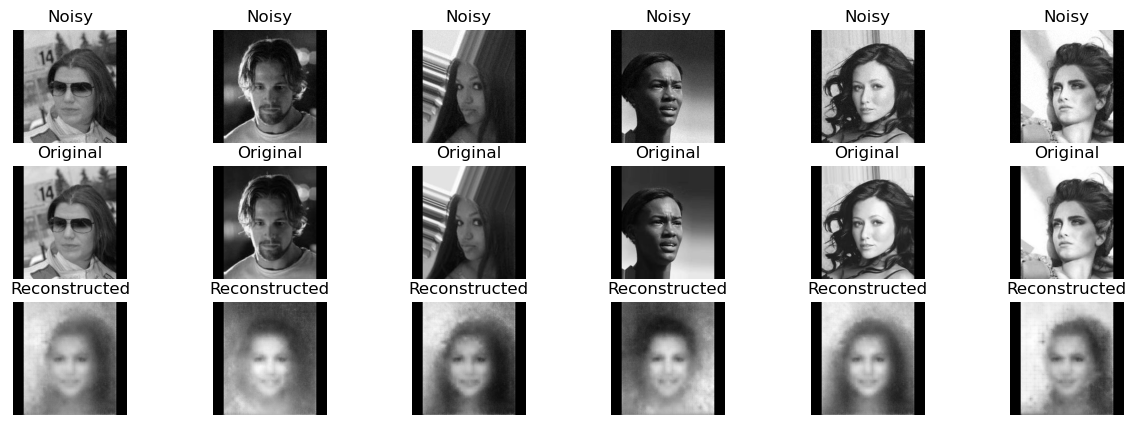

In [30]:
def visualize_results(model, dataloader, num_images=6):
    model.eval()
    dataiter = iter(dataloader)
    noisy_images, original_images = next(dataiter)
    noisy_images, original_images = noisy_images.to(device), original_images.to(device)

    # Obtener las imágenes reconstruidas
    with torch.no_grad():
        reconstructed_images, _, _ = model(noisy_images)

    # Mover los tensores a CPU para visualización
    noisy_images = noisy_images.cpu().numpy()
    original_images = original_images.cpu().numpy()
    reconstructed_images = reconstructed_images.cpu().numpy()

    # Visualización
    fig, axs = plt.subplots(3, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Imágenes con ruido
        axs[0, i].imshow(noisy_images[i].squeeze(), cmap='gray')
        axs[0, i].title.set_text('Noisy')
        axs[0, i].axis('off')

        # Imágenes originales
        axs[1, i].imshow(original_images[i].squeeze(), cmap='gray')
        axs[1, i].title.set_text('Original')
        axs[1, i].axis('off')

        # Imágenes reconstruidas
        axs[2, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
        axs[2, i].title.set_text('Reconstructed')
        axs[2, i].axis('off')

    plt.show()

# Llamar a la función para visualizar los resultados
visualize_results(model, dataloader)

## Cross Validation with 5 folds

In [36]:
noisy_images_1000 = np.load('celeba_noisy_1000.npy')
original_images_1000 = np.load('celeba_original_1000.npy')

images_train, images_test, original_images_train, original_images_test = train_test_split(
    noisy_images_1000, original_images_1000, test_size=100, random_state=42
)

# Convierte a tensores y carga en DataLoader como antes
train_noisy_tensors, train_original_tensors = load_dataset(images_train, original_images_train)
test_noisy_tensors, test_original_tensors = load_dataset(images_test, original_images_test)

train_dataloader = prepare_dataloader(train_noisy_tensors, train_original_tensors)
test_dataloader = prepare_dataloader(test_noisy_tensors, test_original_tensors)

In [46]:
# cross validation (5 folds)

# hyperparameter search grid
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
batch_sizes = [16, 32, 64]
num_epochs = [4]

# best hyperparameters
best_loss = float('inf')
best_hyperparameters = None


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Función para entrenar el modelo en un fold
def train_model(model, train_dataloader, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for data, target in train_dataloader:
            optimizer.zero_grad()
            output, mu, logvar = model(data.to(device))
            loss = loss_function(output, target.to(device), mu, logvar)
            loss.backward()
            optimizer.step()
    return model

# Función para evaluar el modelo
def evaluate_model(model, test_dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            output, mu, logvar = model(data.to(device))
            loss = loss_function(output, target.to(device), mu, logvar)
            total_loss += loss.item()
    return total_loss / len(test_dataloader.dataset)

In [48]:
images = np.load('celeba_noisy_1000.npy')
original_images = np.load('celeba_original_1000.npy')

images_tensor = torch.tensor(images, dtype=torch.float32) / 255.0
original_images_tensor = torch.tensor(original_images, dtype=torch.float32) / 255.0

# Convertimos a tensores y añadimos la dimensión de canal
images_tensor = images_tensor.unsqueeze(1)
original_images_tensor = original_images_tensor.unsqueeze(1)


# K-fold Cross Validation model evaluation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Buscar hiperparámetros
for learning_rate in tqdm(learning_rates):
    for batch_size in batch_sizes:
        for num_epoch in num_epochs:
            fold_losses = []
            for fold, (train_idx, test_idx) in enumerate(kfold.split(images_tensor)):
                # Extraer los subconjuntos de datos para el fold actual
                train_images = images_tensor[train_idx]
                train_originals = original_images_tensor[train_idx]
                test_images = images_tensor[test_idx]
                test_originals = original_images_tensor[test_idx]

                # Crear TensorDataset usando los tensores extraídos
                train_dataset = TensorDataset(train_images, train_originals)
                test_dataset = TensorDataset(test_images, test_originals)

                # Crear DataLoader para entrenamiento y pruebas
                train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                # Inicializar modelo y optimizador
                model = VAE().to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                # Entrenar el modelo
                model = train_model(model, train_dataloader, optimizer, num_epoch)

                # Evaluar el modelo
                loss = evaluate_model(model, test_dataloader)
                fold_losses.append(loss)

            # Calcular la pérdida promedio de los folds
            mean_loss = np.mean(fold_losses)
            print(f"LR: {learning_rate}, BS: {batch_size}, Epochs: {num_epoch}, Loss: {mean_loss}")

            # Actualizar los mejores hiperparámetros
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_hyperparameters = (learning_rate, batch_size, num_epoch)

print("Best Hyperparameters:", best_hyperparameters)

  0%|          | 0/4 [08:07<?, ?it/s]


KeyboardInterrupt: 

Este código fue copiado a un google colab para correrlo con la VM.